<a href="https://colab.research.google.com/github/prajakta311/git---session/blob/main/The_Aviation_Forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima.model import ARIMA

Loading Airpassenger Dataset

In [3]:
airpass = pd.read_csv('AirPassengers.csv')

Let's check first 5 and last 5 records of data set

In [4]:
airpass.head(5)

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [5]:
airpass.tail(5)

,Month,#Passengers
139,1960-08,606
140,1960-09,508
141,1960-10,461
142,1960-11,390
143,1960-12,432


Let's rename "#Passengers", seems really annoying the column name.

In [6]:
airpass.rename(columns={'#Passengers':'Passengers'},inplace=True)

In [7]:
airpass.head()

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [8]:
airpass.shape

(144, 2)

In [9]:
airpass.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Month       144 non-null    object
 1   Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


There are 144 records in 2 datasets and 2 columns. There are no null records present. But, look at the Month column. We need to convert them in to datetime datatype.

In [10]:
from datetime import datetime
airpass['Month']=pd.to_datetime(airpass['Month'],infer_datetime_format=True)

In [11]:
airpass.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Month       144 non-null    datetime64[ns]
 1   Passengers  144 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 2.4 KB


Now, we will need to index Month column.

In [12]:
airpassind = airpass.set_index('Month',inplace=False)

In [13]:
airpassind.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


Let's plot the data

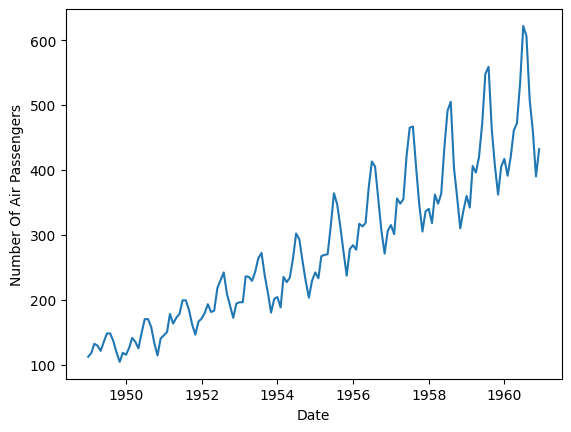

In [14]:
plt.xlabel('Date')
plt.ylabel('Number Of Air Passengers')
plt.plot(airpassind)

From the above below, we can see that there is a Trend compoenent in the series. Hence, we now check for stationarity of the data.

Let's make one function consisting of stationary data checking and ADCF test working. Because we will need to repeat the steps many times, therefore, making function will become very handy

In [15]:
def test_stationarity(timeseries):

    #Determine rolling statistics
    movingAverage = timeseries.rolling(window=12).mean()
    movingSTD = timeseries.rolling(window=12).std()

    #Plot rolling statistics
    plt.plot(timeseries, color='blue', label='Original')
    plt.plot(movingAverage, color='red', label='Rolling Mean')
    plt.plot(movingSTD, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

    #Perform Dickey–Fuller test:
    print('Results of Dickey Fuller Test:')
    airpass_test = adfuller(timeseries['Passengers'], autolag='AIC')
    dfoutput = pd.Series(airpass_test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in airpass_test[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

Let's determine & plot rolling statistics.

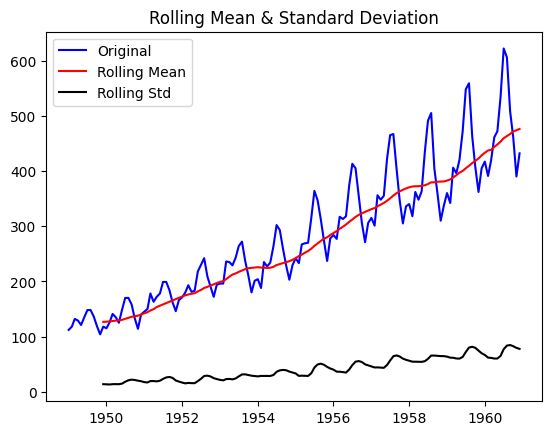

Results of Dickey Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [16]:
test_stationarity(airpassind)

From above plot, we can see that Rolling Mean itself has a trend component even though Rolling Standard Deviation is fairly constant with time.

For time series to be stationary, we need to ensure that both Rolling Mean and Rolling Standard Deviation remain fairly constant WRT time.

Both the curves needs to be parallel to X-Axis, in our case it is not so.

We've also conducted the ADCF ie Augmented Dickey Fuller Test. Having the Null Hypothesis to be Time Series is Non Stationary.

Now, we will have to perform some data transformation to achieve Stationarity. We can perform any of the transformations like taking log scale, square, square root, cube, cube root, time shift, exponential decay, etc.

Let's perform Log Transformation.

Basically we need to remove the trend component.

In [17]:
airpass_log = np.log(airpassind)

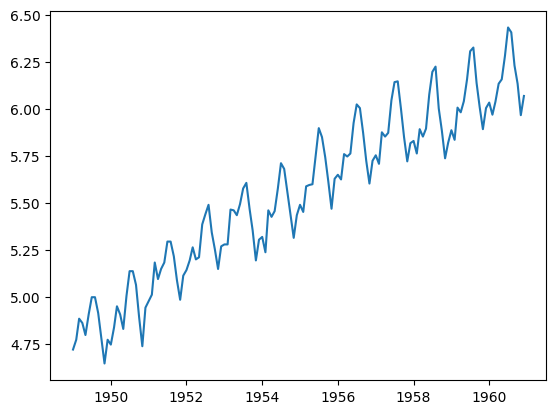

In [18]:
plt.plot(airpass_log)

Working on Rolling stats seperately (not using function) because we would need Rolling stats separately for computing

In [19]:
rollmean_log = airpass_log.rolling(window=12).mean()
rollstd_log = airpass_log.rolling(window=12).std()

Text(0.5, 1.0, 'Rolling Mean & Standard Deviation (Logarithmic Scale)')

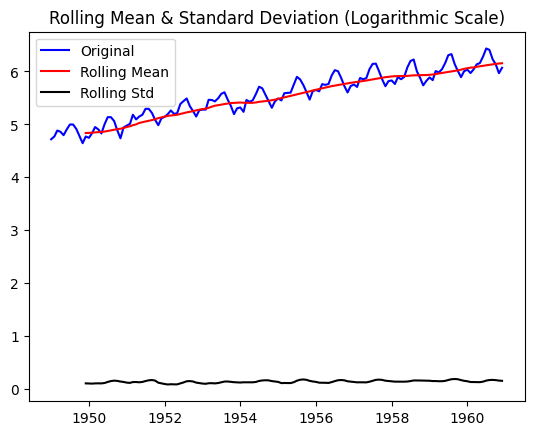

In [20]:
plt.plot(airpass_log, color='blue', label='Original')
plt.plot(rollmean_log, color='red', label='Rolling Mean')
plt.plot(rollstd_log, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation (Logarithmic Scale)')

From above graph we can say that, we slightly bettered our previous results. Now, we are heading into the right direction.

From the above graph, Time series with log scale as well as Rolling Mean(moving avg) both have the trend component. Thus subtracting one from the other should remove the trend component.

R (result) = Time Series Loca Scale - Rolling Mean Log Scale -> this can be our final non trend curve

In [21]:
airpass_new = airpass_log - rollmean_log

In [22]:
airpass_new.head()

,Passengers
Month,
1949-01-01,NaN
1949-02-01,NaN
1949-03-01,NaN
1949-04-01,NaN
1949-05-01,NaN


In [23]:
airpass_new.dropna(inplace=True)

In [24]:
airpass_new.head()

,Passengers
Month,
1949-12-01,-0.065494
1950-01-01,-0.093449
1950-02-01,-0.007566
1950-03-01,0.099416
1950-04-01,0.052142


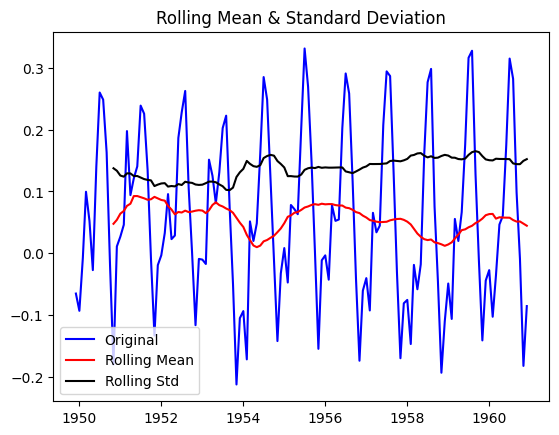

Results of Dickey Fuller Test:
Test Statistic                  -3.162908
p-value                          0.022235
#Lags Used                      13.000000
Number of Observations Used    119.000000
Critical Value (1%)             -3.486535
Critical Value (5%)             -2.886151
Critical Value (10%)            -2.579896
dtype: float64


In [25]:
test_stationarity(airpass_new)

From the above plot, we came to know that "indeed subtracting two related series having similar trend components actually removed trend and made the dataset stationary"

Also, after concluding the results from ADFC test:

p-value has reduced from 0.99 to 0.022
Critical values at 1%,5%,10% confidence intervals are pretty close to the Test Statistic
So we can now say that given series is now STATIONARY

Time Shift Transformation

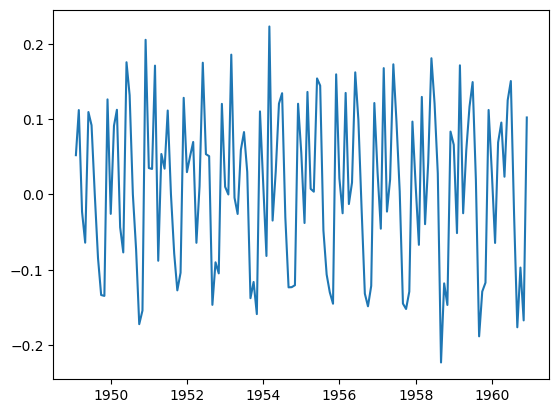

In [27]:
airpass_log_diff = airpass_log - airpass_log.shift()
plt.plot(airpass_log_diff)

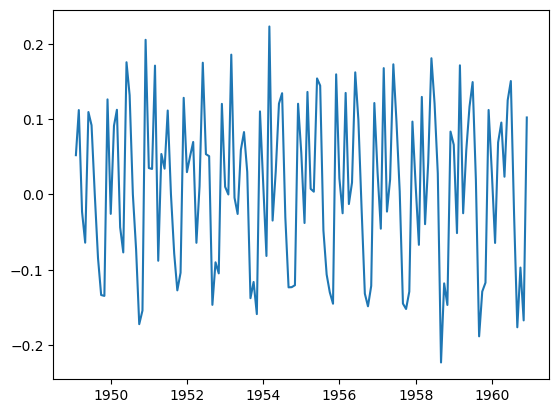

In [28]:
airpass_log_diff.dropna(inplace=True)
plt.plot(airpass_log_diff)

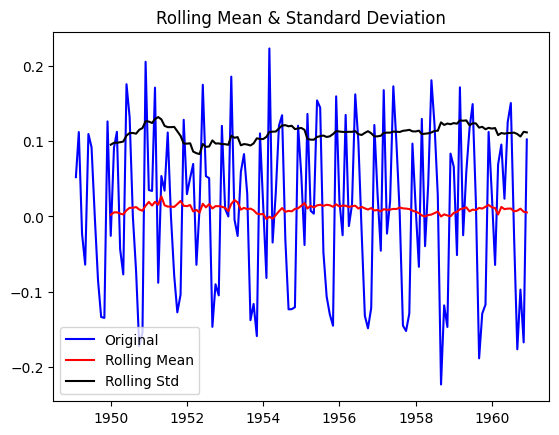

Results of Dickey Fuller Test:
Test Statistic                  -2.717131
p-value                          0.071121
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64


In [29]:
test_stationarity(airpass_log_diff)

From above plot, we can see that, visually this is the very best result as our series along with rolling stats values of moving avg(mean) & moving standard deviation is very much flat & stationary.

But, the ADCF test shows us that:

p-value of 0.07 is not as good as 0.02 of previous instance.
Test Statistic value not as close to the critical values as that of previous instance.

Let us now break down the 3 components of the log scale series using a system libary function. Once, we separate our the components, we can simply ignore trend & seasonality and check on the nature of the residual part.

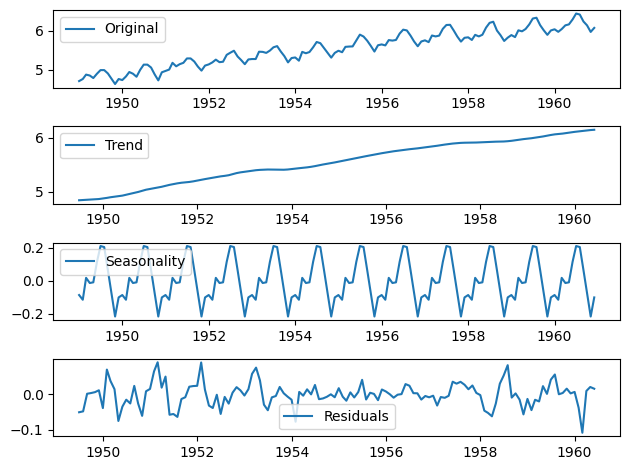

In [30]:
decomposition = seasonal_decompose(airpass_log)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(airpass_log, label='Original')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

There can be cases where an observation simply consist of trend & seasonality. In that case, there won't be any residual component & that would be a null or NaN. Hence, we also remove such cases.

In [31]:
airpass_decompose = residual
airpass_decompose.dropna(inplace=True)

Text(0.5, 1.0, 'Rolling Mean & Standard Deviation')

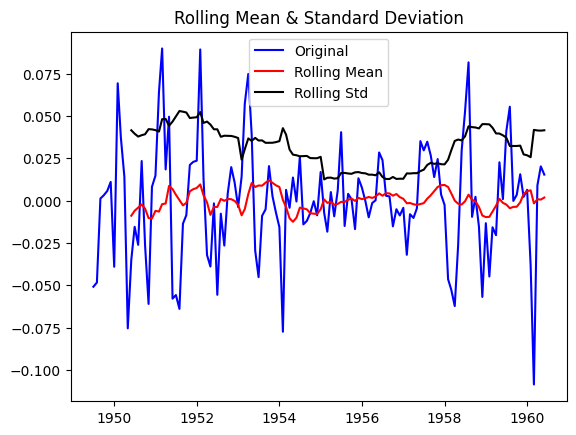

In [32]:
rollmean_decompose = airpass_decompose.rolling(window=12).mean()
rollstd_decompose = airpass_decompose.rolling(window=12).std()

plt.plot(airpass_decompose, color='blue', label='Original')
plt.plot(rollmean_decompose, color='red', label='Rolling Mean')
plt.plot(rollstd_decompose, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')

Plotting ACF & PACF

In [33]:
lag_acf = acf(airpass_log_diff, nlags=20)
lag_pacf = pacf(airpass_log_diff, nlags=20, method='ols')

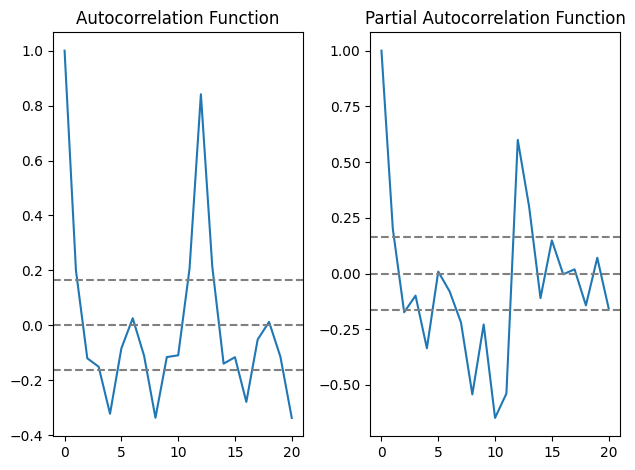

In [34]:
#Plot ACF:
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(airpass_log_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(airpass_log_diff)), linestyle='--', color='gray')
plt.title('Autocorrelation Function')

#Plot PACF
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(airpass_log_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(airpass_log_diff)), linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function')

plt.tight_layout()

From the ACF graph, we can see that curve touches y=0.0 line at x=2. Thus, from theory, Q = 2 From the PACF graph, we see that curve touches y=0.0 line at x=2. Thus, from theory, P = 2

ARIMA is AR + I + MA. Before, we see an ARIMA model, let us check the results of the individual AR & MA model. Note that, these models will give a value of RSS. Lower the RSS values indicates a better model.

**AR Model**
Making order = (2,1,0)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Plotting AR model


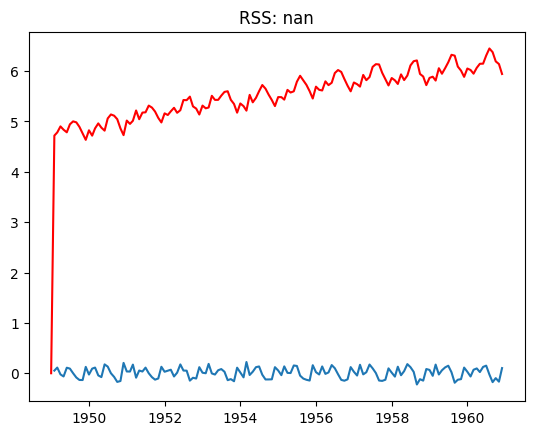

In [35]:
model1 = ARIMA(airpass_log, order=(2,1,0))
results_AR = model1.fit()
plt.plot(airpass_log_diff)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'%sum((results_AR.fittedvalues - airpass_log_diff['Passengers'])**2))
print('Plotting AR model')

**MA Model**

Making order = (0,1,2)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Plotting MA model


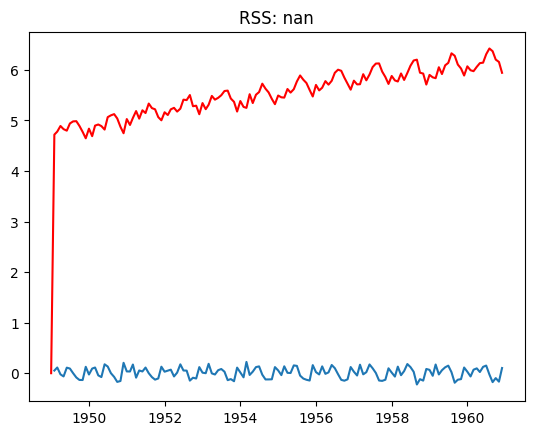

In [36]:
model2 = ARIMA(airpass_log, order=(0,1,2))
results_MA = model2.fit()
plt.plot(airpass_log_diff)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('RSS: %.4f'%sum((results_MA.fittedvalues - airpass_log_diff['Passengers'])**2))
print('Plotting MA model')

AR+I+MA = ARIMA Model

Making order = (2,1,2)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Plotting ARIMA model


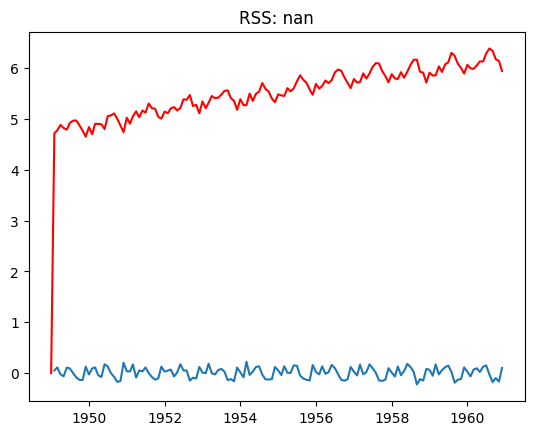

In [37]:
model = ARIMA(airpass_log, order=(2,1,2))
results_ARIMA = model.fit()
plt.plot(airpass_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'%sum((results_ARIMA.fittedvalues - airpass_log_diff['Passengers'])**2))
print('Plotting ARIMA model')

RSS value for: AR Model - 1.5023 MA Model - 1.4721

ARIMA Model - 1.0292

By combining AR & MA into ARIMA, we see that RSS value has decreased from either case to 1.0292, indicating ARIMA to be better than its individual component models.

With the ARIMA model built, we will now generate predictions. But, before we do any plots for predictions ,we need to reconvert the predictions back to original form. This is because, our model was built on log transformed data.

**Prediction & Reverse Transformation**

In [38]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
predictions_ARIMA_diff.head()

Month
1949-01-01    0.000000
1949-02-01    4.718499
1949-03-01    4.776385
1949-04-01    4.883216
1949-05-01    4.824421
dtype: float64

In [39]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_diff_cumsum.head()

Month
1949-01-01     0.000000
1949-02-01     4.718499
1949-03-01     9.494884
1949-04-01    14.378100
1949-05-01    19.202522
dtype: float64

In [40]:
predictions_ARIMA_log = pd.Series(airpass_log['Passengers'].iloc[0], index=airpass_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)
predictions_ARIMA_log.head()

Month
1949-01-01     4.718499
1949-02-01     9.436998
1949-03-01    14.213383
1949-04-01    19.096599
1949-05-01    23.921020
dtype: float64

Inverse of log is exp

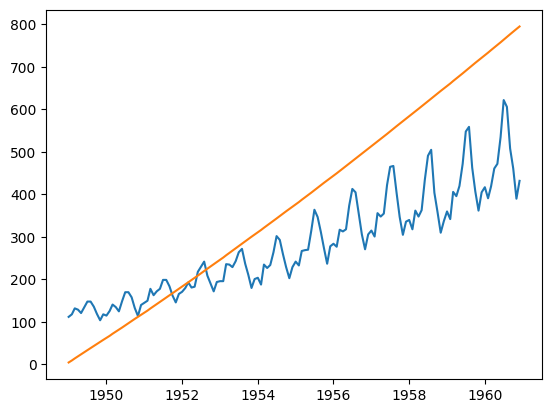

In [41]:
predictions_ARIMA = predictions_ARIMA_log
plt.plot(airpassind)
plt.plot(predictions_ARIMA)

From above plot, we can see that our predicted forecasts are very close to the real time series values. It also indicates a fairly accurate model.

In [42]:
airpass_log.head()

,Passengers
Month,
1949-01-01,4.718499
1949-02-01,4.770685
1949-03-01,4.882802
1949-04-01,4.859812
1949-05-01,4.795791


We have 144 (existing data of 12 yrs in months) data points. Now, we want to forecast for additional 10 yrs (10x12 months=120 data points).

144+120 = 264 records/data points